# Regression on Boston House Prices dataset using the new kernel

In [33]:
import matplotlib.pyplot as plt # 3.6
import numpy as np # 1.22.4
import tensorflow as tf # 2.11.0
import gpflow # 2.7.0
import pandas as pd
import tensorflow_probability as tfp
from tensorflow import keras
import seaborn as sns
import torch
from tensorflow.python.ops.numpy_ops import np_config
from LambdaRBF import LambdaRBF
from utils import plot_matrix, get_lower_triangular_from_diag, create_dataset, measure_rmse
np_config.enable_numpy_behavior()
plt.rcParams["figure.figsize"] = (12, 6)
plt.style.use("ggplot")
print('tensorflow ', tf.__version__) 
print('pytorch ', torch.__version__) 
print('numpy ', np.__version__) 
print('gpflow ', gpflow.__version__) 
print('pandas ', pd.__version__) 

tensorflow  2.11.0
pytorch  1.13.1
numpy  1.22.4
gpflow  2.7.0
pandas  1.5.3


Load Boston dataset

In [34]:
X_train, Y_train,  X_test, Y_test, Y_train_mean, Y_train_std = create_dataset('boston', 0)

In [2]:
""" Keras
(X_train, Y_train), (X_test, Y_test) = keras.datasets.boston_housing.load_data()
Y_train = np.atleast_2d(Y_train).T
Y_test = np.atleast_2d(Y_test).T
Y_train_mean, Y_train_std = Y_train.mean(0), Y_train.std(0) + 1e-9
Y_train = (Y_train - Y_train_mean) / Y_train_std
Y_test = (Y_test - Y_train_mean) / Y_train_std
D = X_train.shape[1]
#X_train = X_train[:,0:D]
"""

Visualize the correlation matrix

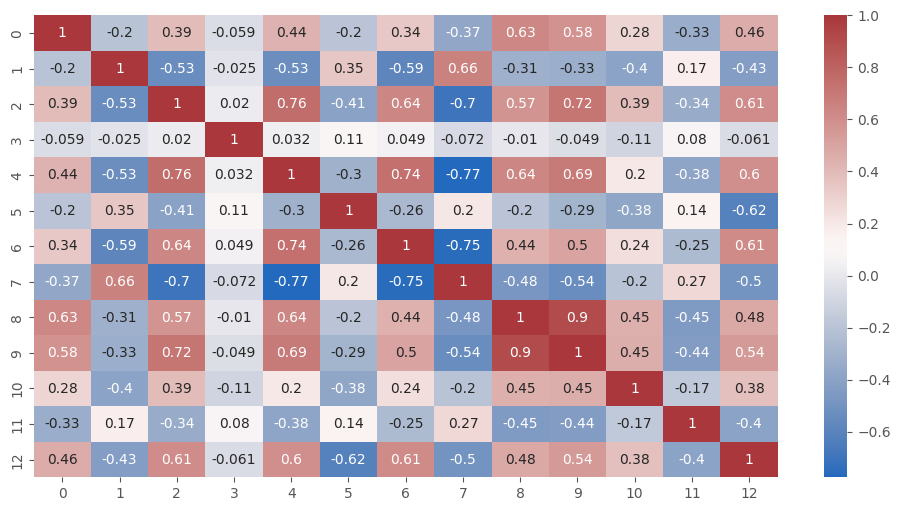

In [35]:
plot_matrix(X_train, correlation=True)

Show that the Lambda RBF kernel is equivalent in the computation of the kernel matrix

In [36]:
D=13
# Define the lengthscales according to the RBF kernel standard
lengthscales = tf.constant([D**0.5]*D, dtype=tf.float64)
# Obtain the matrix L such that LLᵀ=Λ and Λ=inv(diag(lengthscales))
Lambda_L = get_lower_triangular_from_diag(lengthscales)
# Convert it into the triangular representation
Lambda_L_array = tfp.math.fill_triangular_inverse(Lambda_L)

LRBF = LambdaRBF(Lambda_L_array, 1.0)
lrbf = LRBF.K(X_train)[5,3]

# Standard RBF kernel
RBF = gpflow.kernels.SquaredExponential(variance=1, lengthscales=(D**0.5)*np.ones(D))
rbf = RBF.K(X_train)[5,3]
print('LambdaRBF val: ', lrbf)
print('RBF val: ',rbf)

LambdaRBF val:  tf.Tensor(0.3518335889365919, shape=(), dtype=float64)
RBF val:  tf.Tensor(0.3518335889365918, shape=(), dtype=float64)


Obtain the LRBF for a generic matrix (not diagonal)

In [37]:
D = 13
ts = gpflow.utilities.bijectors.triangular_size(D)
# Define an array that represents the entire L matrix
Lambda_L_array_full = tf.constant([D**0.5]*ts, dtype=tf.float64)

LRBF = LambdaRBF(Lambda_L_array_full, 1.0)
LRBF.K(X_train)[5,3]

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

## Compare the RBF kernel with LambdaRBF with equivalent starting lengthscales

### The Covariance matrix

We are going to extend the Automatic Relevance Determination techique tipically used togheter with stationary kernels like Squared Exponential (RBF).

We are working on the prior probabability $p(\textbf{f}|\Theta)$. The prior knowledge is expressed by the precomputed Kernel matrix $K_{xx|\Theta}$ where $K_{xx|\Theta}[i,j] = k(x_i,x_j|\Theta)$. \\
The RBF kernel function $k$ is defined as:
$$k(x_i,x_j|\sigma_f^2,\Lambda) = \sigma_f^2e^{-\frac{1}{2}(x_i-x_j)^T\Lambda(x_i-x_j)}$$
where $\Lambda$ is the precision matrix of the kernel.

In ARD the precision matrix of the kernel is of the form:
$$diag([\alpha_0,\alpha_1,...,\alpha_{D-1}])$$ 
where $D$ is the number of features. The values on the diagonal are called lengthscales because they represent a form of scaling of the squared norm that is computed among couples of feature vectors. 

What we are willing to do is extending the ARD mechanism to a more general one where we can optimize for the entire precision matrix $\Lambda$ instead of only the diagonal (explain here the link between a zero in the precision matrix and conditional independence). For this purpose we are going to design a modified version of the RBF kernel in which the trainable hyperparameters are $\sigma_f^2$ and the full matrix $\Lambda$

In [38]:
D = X_train.shape[1] 
lambda_i = D**0.5
lengthscales_array = lambda_i*np.ones(D)
print(lengthscales_array)

[3.60555128 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128
 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128
 3.60555128]


$$k(x_i,x_j|\sigma_f^2,\Lambda) = \sigma_f^2e^{||\frac{X-X2^T}{\textbf{l}}||^2}$$
where $\textbf{l}$ is a $D$-dimensional array containing the lengthscales of each dimension $[\lambda_0,\lambda_1,...,\lambda_D]$. If we suppose $D=2$ we can express the scaled norm between two samples as:
$$||\frac{x_i-x_j}{\textbf{l}}||^2 = (x_i-x_j)^T\begin{bmatrix} l_0 & 0 \\ 0 & l_1 \end{bmatrix}^{-1}(x_i-x_j) = (x_i-x_j)^T\begin{bmatrix} \lambda_0 & 0 \\ 0 & \lambda_1 \end{bmatrix}(x_i-x_j)$$

$$\lambda_i = \frac{1}{l_i^2}$$
$$l_i = \sqrt{\frac{1}{\lambda_i}}$$

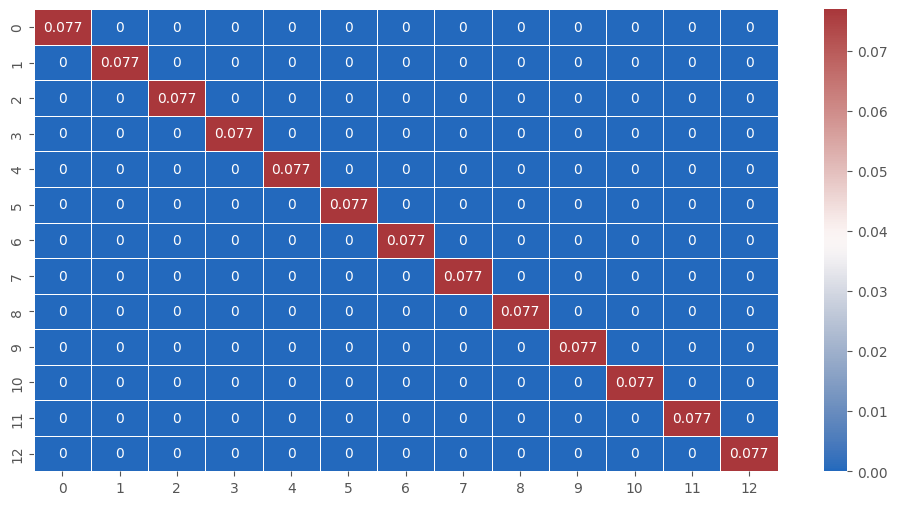

In [39]:
lengthscales = tf.constant([lambda_i]*D, dtype=tf.float64)
Lambda_L = get_lower_triangular_from_diag(lengthscales)
plot_matrix(tf.matmul(Lambda_L, tf.transpose(Lambda_L)))

The inverse of this matrix $\Lambda$ has the $lengthscales\_array$ on the diagonal

In [40]:
lambda_i = D**0.5
# Define the lengthscales according to the RBF kernel standard
lengthscales = tf.constant([lambda_i]*D, dtype=tf.float64)
# Obtain the matrix L such that LLᵀ=Λ and Λ=inv(diag(lengthscales))
Lambda_L = get_lower_triangular_from_diag(lengthscales)
# Convert it into the triangular representation
Lambda_L_array = tfp.math.fill_triangular_inverse(Lambda_L)

LRBF = LambdaRBF(Lambda_L_array, 1.0)
lrbf = LRBF.K(X_train)[5,3]

# Standard RBF kernel
RBF = gpflow.kernels.SquaredExponential(variance=1, lengthscales=(D**0.5)*np.ones(D))
rbf = RBF.K(X_train)[5,3]
print('LambdaRBF val: ', lrbf)
print('RBF val: \t',rbf)

LambdaRBF val:  tf.Tensor(0.3518335889365919, shape=(), dtype=float64)
RBF val: 	 tf.Tensor(0.3518335889365918, shape=(), dtype=float64)


### LambdaRBF kernel - no priors

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,Identity,,True,"(91,)",float64,"[0.27735, 0., 0...."
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lambda diagonal:  [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
--- Final values ---
Variance: 1.685


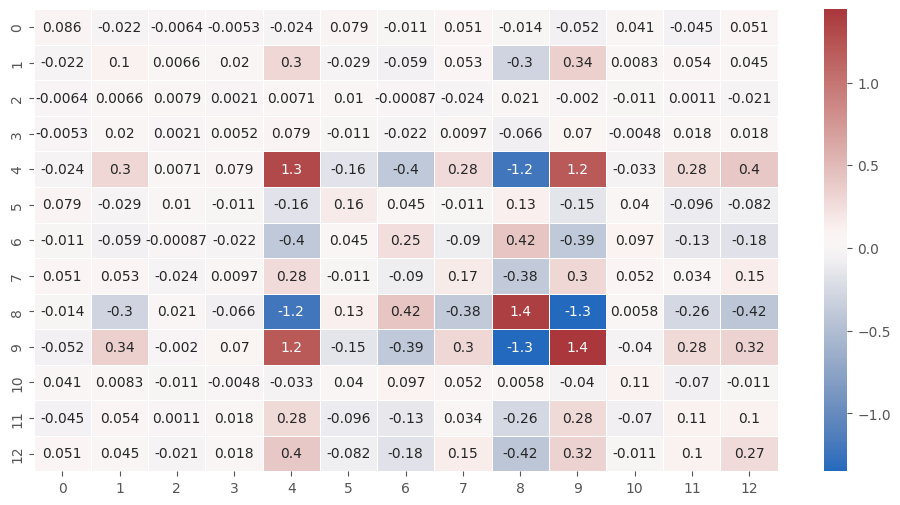

In [10]:
D = 13
# Define the kernel and put a Normal prior
lengthscales = tf.constant([D**0.5]*D, dtype=tf.float64)
Lambda_L = get_lower_triangular_from_diag(lengthscales)
Lambda_L_array = tfp.math.fill_triangular_inverse(Lambda_L)
LRBF = LambdaRBF(Lambda_L_array, 1.0)
#LRBF.Lambda_L.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(1.), scale=gpflow.utilities.to_default_float(1.))
#LRBF.variance.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(0.05), scale=gpflow.utilities.to_default_float(1.))

# GPR model (no approx)
model_LRBF = gpflow.models.GPR(
    (X_train, Y_train),
    kernel=LRBF,
)
gpflow.utilities.print_summary(model_LRBF, fmt="notebook")
print('--- Initial values ---')
print('Variance: %.3f'%(LRBF.variance.numpy()))
print('Lambda diagonal: ', tf.linalg.diag_part(LRBF.get_Lambda()).numpy())
opt = gpflow.optimizers.Scipy()
opt.minimize(model_LRBF.training_loss, model_LRBF.trainable_variables)
print('--- Final values ---')
print('Variance: %.3f'%(LRBF.variance.numpy()))
plot_matrix(LRBF.get_Lambda())

In [11]:
train_rmse_stan, test_rmse_stan = measure_rmse(model_LRBF, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.125
Test RMSE (Standardised): 0.483


### RBF kernel (standard) - no priors

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(13,)",float64,"[3.60555, 3.60555, 3.60555..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lengthscales:  [3.60555128 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128
 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128
 3.60555128]
--- Final values ---
Variance: 1.449
Lengthscales:  [6.56772382e+00 1.02828585e+01 1.85135772e+03 3.83219134e+03
 6.75633633e-01 3.14068147e+00 3.94581257e+00 5.02214116e+00
 4.56209545e+00 1.22476976e+00 4.83424957e+00 9.68222842e+00
 1.84917395e+00]


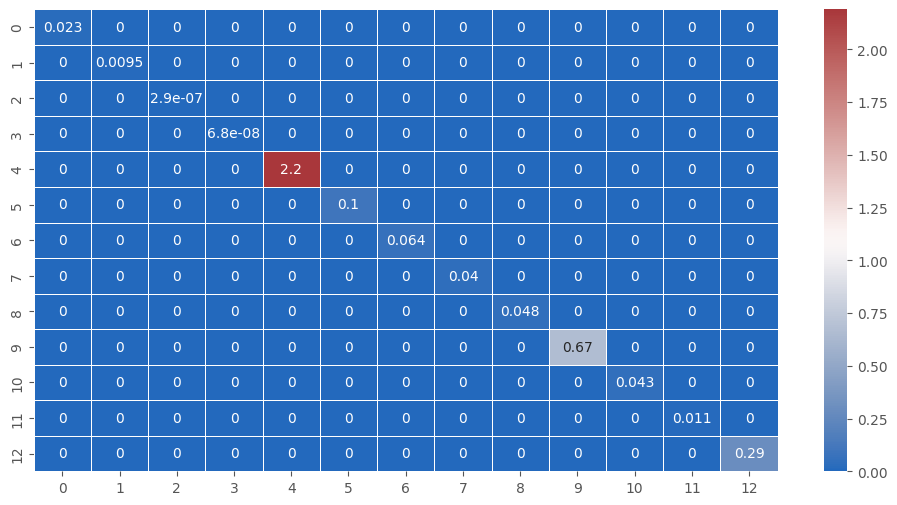

In [15]:
RBF = gpflow.kernels.SquaredExponential(variance=1, lengthscales=(D**0.5)*np.ones(D))
#k.lengthscales.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(1.), scale=gpflow.utilities.to_default_float(1.))
#k.variance.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(0.05), scale=gpflow.utilities.to_default_float(1.))
model_RBF = gpflow.models.GPR(
    (X_train, Y_train),
    kernel=RBF,
)
gpflow.utilities.print_summary(model_RBF, fmt="notebook")
print('--- Initial values ---')
print('Variance: %.3f'%(RBF.variance.numpy()))
print('Lengthscales: ', RBF.lengthscales.numpy())
opt = gpflow.optimizers.Scipy()
opt.minimize(model_RBF.training_loss, model_RBF.trainable_variables)
print('--- Final values ---')
print('Variance: %.3f'%(RBF.variance.numpy()))
print('Lengthscales: ', RBF.lengthscales.numpy())
Lambda_L_RBF = get_lower_triangular_from_diag(RBF.lengthscales.numpy())
plot_matrix(tf.matmul(Lambda_L_RBF, tf.transpose(Lambda_L_RBF)))

In [14]:
train_rmse_stan, test_rmse_stan = measure_rmse(model_RBF, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.142
Test RMSE (Standardised): 0.436


## Introducing a prior on hyperparameters

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,Identity,Normal,True,"(91,)",float64,"[0.27735, 0., 0...."
GPR.kernel.variance,Parameter,Softplus,Normal,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lambda diagonal:  [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
--- Final values ---
Variance: 0.844


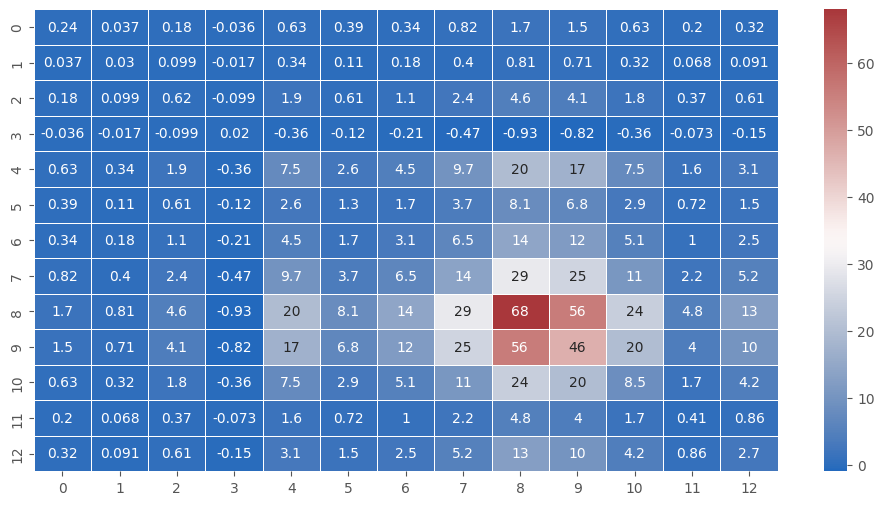

In [41]:
D = 13
# Define the kernel and put a Normal prior
lengthscales = tf.constant([D**0.5]*D, dtype=tf.float64)
Lambda_L = get_lower_triangular_from_diag(lengthscales)
Lambda_L_array = tfp.math.fill_triangular_inverse(Lambda_L)
LRBF = LambdaRBF(Lambda_L_array, 1.0)
LRBF.Lambda_L.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(np.sqrt(D)), scale=gpflow.utilities.to_default_float(1.))
#LRBF.variance.prior = tfp.distributions.Gamma(concentration=gpflow.utilities.to_default_float(0.), rate=gpflow.utilities.to_default_float(1.0))
LRBF.variance.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(0.05), scale=gpflow.utilities.to_default_float(1.))

# GPR model (no approx)
model_LRBF = gpflow.models.GPR(
    (X_train, Y_train),
    kernel=LRBF,
)
gpflow.utilities.print_summary(model_LRBF, fmt="notebook")
print('--- Initial values ---')
print('Variance: %.3f'%(LRBF.variance.numpy()))
print('Lambda diagonal: ', tf.linalg.diag_part(LRBF.get_Lambda()).numpy())
opt = gpflow.optimizers.Scipy()
opt.minimize(model_LRBF.training_loss, model_LRBF.trainable_variables)
print('--- Final values ---')
print('Variance: %.3f'%(LRBF.variance.numpy()))
plot_matrix(LRBF.get_Lambda())

In [42]:
train_rmse_stan, test_rmse_stan = measure_rmse(model_LRBF, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.057
Test RMSE (Standardised): 0.522


## Results on other datasets

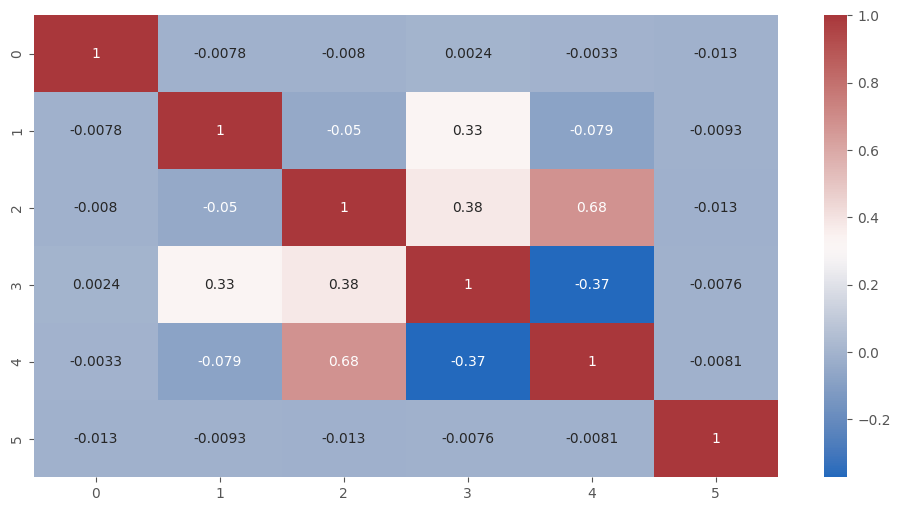

In [27]:
X_train, Y_train,  X_test, Y_test, Y_train_mean, Y_train_std = create_dataset('yacht', 0)
plot_matrix(X_train, correlation=True)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,Identity,,True,"(21,)",float64,"[0.40825, 0., 0...."
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lambda diagonal:  [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
--- Final values ---
Variance: 5.721


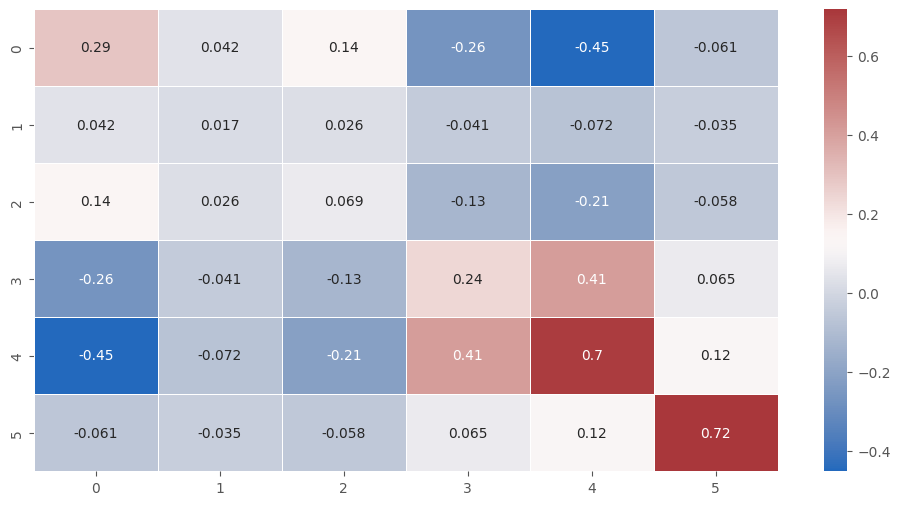

In [28]:
D = X_train.shape[1]
# Define the kernel and put a Normal prior
lengthscales = tf.constant([D**0.5]*D, dtype=tf.float64)
Lambda_L = get_lower_triangular_from_diag(lengthscales)
Lambda_L_array = tfp.math.fill_triangular_inverse(Lambda_L)
LRBF = LambdaRBF(Lambda_L_array, 1.0)
#LRBF.Lambda_L.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(1.), scale=gpflow.utilities.to_default_float(1.))
#LRBF.variance.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(0.05), scale=gpflow.utilities.to_default_float(1.))

# GPR model (no approx)
model_LRBF = gpflow.models.GPR(
    (X_train, Y_train),
    kernel=LRBF,
)
gpflow.utilities.print_summary(model_LRBF, fmt="notebook")
print('--- Initial values ---')
print('Variance: %.3f'%(LRBF.variance.numpy()))
print('Lambda diagonal: ', tf.linalg.diag_part(LRBF.get_Lambda()).numpy())
opt = gpflow.optimizers.Scipy()
opt.minimize(model_LRBF.training_loss, model_LRBF.trainable_variables)
print('--- Final values ---')
print('Variance: %.3f'%(LRBF.variance.numpy()))
plot_matrix(LRBF.get_Lambda())

In [29]:
train_rmse_stan, test_rmse_stan = measure_rmse(model_LRBF, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.010
Test RMSE (Standardised): 0.020


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(6,)",float64,"[2.44949, 2.44949, 2.44949..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lengthscales:  [2.44948974 2.44948974 2.44948974 2.44948974 2.44948974 2.44948974]
--- Final values ---
Variance: 0.742
Lengthscales:  [5.23417794e+00 4.43086052e+00 4.00634789e+03 7.11481299e+00
 1.86828911e+00 4.01687729e-01]


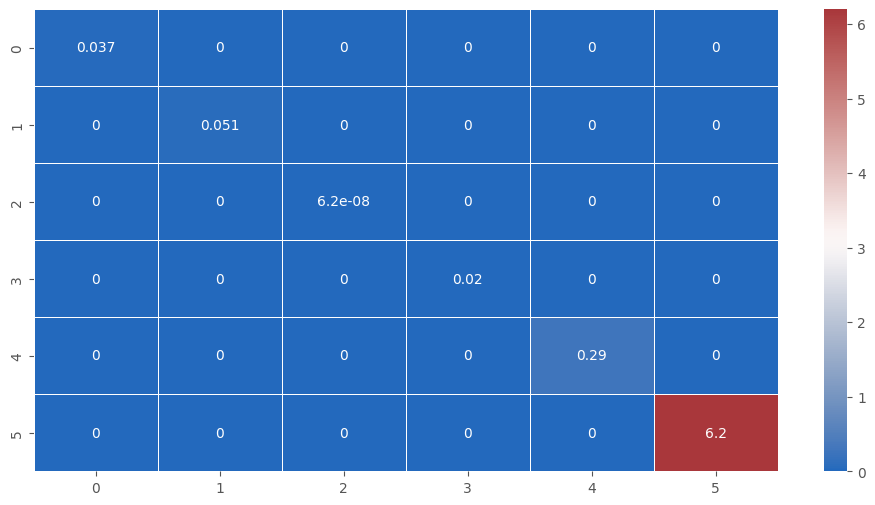

In [30]:
RBF = gpflow.kernels.SquaredExponential(variance=1, lengthscales=(D**0.5)*np.ones(D))
#k.lengthscales.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(1.), scale=gpflow.utilities.to_default_float(1.))
#k.variance.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(0.05), scale=gpflow.utilities.to_default_float(1.))
model_RBF = gpflow.models.GPR(
    (X_train, Y_train),
    kernel=RBF,
)
gpflow.utilities.print_summary(model_RBF, fmt="notebook")
print('--- Initial values ---')
print('Variance: %.3f'%(RBF.variance.numpy()))
print('Lengthscales: ', RBF.lengthscales.numpy())
opt = gpflow.optimizers.Scipy()
opt.minimize(model_RBF.training_loss, model_RBF.trainable_variables)
print('--- Final values ---')
print('Variance: %.3f'%(RBF.variance.numpy()))
print('Lengthscales: ', RBF.lengthscales.numpy())
Lambda_L_RBF = get_lower_triangular_from_diag(RBF.lengthscales.numpy())
plot_matrix(tf.matmul(Lambda_L_RBF, tf.transpose(Lambda_L_RBF)))

In [31]:
train_rmse_stan, test_rmse_stan = measure_rmse(model_RBF, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.000
Test RMSE (Standardised): 0.039
